In [1]:
import numpy as np

# mapping month number to month name
import calendar

import seaborn as sns
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

[link to the bike rental dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#)

## Lets begin with day-wise analysis

In [2]:
data = pd.read_csv("./christophM_datasets/bike_sharing/day.csv")
display(data.head())

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## data description

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not.
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : **Normalized** temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: **Normalized** feeling(**feels like**) temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: **Normalized** humidity. The values are divided to 100 (max)
- windspeed: **Normalized** wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered 

### Inferences and further operations
1. `cnt` is the dependent variable, to be predicted.
2. `instant` and `dteday` can be filtered out.
3. all categorical variables will now be treatment-coded.
4. since there are 2 years, 2011 and 2012, the problem statement is trifurcated into the following:
    - predicts sales for 2011
    - predicts sales for 2012
    - check why are they different

In [3]:
# drop instant and dteday
data.drop(['instant', 'dteday'], axis=1, inplace=True)
display(data.head(1))

# year separation of dataset
data_2011, data_2012 = data[data['yr'] == 0], data[data['yr'] == 1]

# we can now drop the yr column
data_2011.drop(['yr'], axis=1, inplace=True)
data_2012.drop(['yr'], axis=1, inplace=True)

display(data_2011.head(1))
display(data_2012.head(1))

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
365,1,1,0,0,0,1,0.37,0.375621,0.6925,0.192167,686,1608,2294


# handling the 2011 dataset initially

* check whether the following fields are normalized.
    - `temp`
    - `atemp`
    - `windspeed`
    - `hum`

In [4]:
feature_list = ['temp', 'atemp', 'windspeed', 'hum']
for feature in feature_list:
    print("for feature {}, min = {}, max = {}.".format(feature, min(data_2011[feature]), max(data_2011[feature])))

for feature temp, min = 0.0591304, max = 0.861667.
for feature atemp, min = 0.0790696, max = 0.8408959999999999.
for feature windspeed, min = 0.0223917, max = 0.507463.
for feature hum, min = 0.0, max = 0.9725.


hence they <font color="red">aren't truly normalized</font>.
* though the values are between 0 and 1, the **min** and **max** should have been **exactly 0 and 1**.
* thus we need to normalize(min-max normalization) all features.

In [5]:
x = data_2011['casual']+data_2011['registered'] ==  data_2011['cnt']
x.value_counts()

True    731
dtype: int64

Thus, casual+registered = total counts of bike rented for the day.\
Hence, we now have **2 problem statements(per year), instead of 1**.
1. <font color="Red">predict, based on these environmental conditions, how many **casual renters** rented a bike on a day?</font>
2. <font color="Red">predict, based on these environmental conditions, how many **registered renters** rented a bike on a day?</font>

<font size="4">Checking the monthly counts of the dataset</font>

In [9]:
print("months for 2011 = {}".format(np.unique(data_2011['mnth'])))

months for 2011 = [ 1  2  3  4  5  6  7  8  9 10 11 12]


In [11]:
print("monthly number of entries for 2011:\n{}\n".format(
    dict(zip(calendar.month_name[1:], data_2011['mnth'].value_counts().sort_index().values))
))

monthly number of entries for 2011:
{'January': 31, 'February': 28, 'March': 31, 'April': 30, 'May': 31, 'June': 30, 'July': 31, 'August': 31, 'September': 30, 'October': 31, 'November': 30, 'December': 31}



In [28]:
print(data_2011.shape)

(365, 30)


## Handling Categorical features

In [14]:
print("categories for season:", data_2011['season'].unique())
print("categories for month:", data_2011['mnth'].unique())
print("categories for holiday:", data_2011['holiday'].unique())
print("categories for weekday:", data_2011['weekday'].unique())
print("categories for workingday:", data_2011['workingday'].unique())
print("categories for weathersit:", data_2011['weathersit'].unique())

categories for season: [1 2 3 4]
categories for month: [ 1  2  3  4  5  6  7  8  9 10 11 12]
categories for holiday: [0 1]
categories for weekday: [6 0 1 2 3 4 5]
categories for workingday: [0 1]
categories for weathersit: [2 1 3]


Weather situtation(`weathersit`) **could be thought** of as an <u>ordinal variable</u>, since the encoding is based on the severity of weather.

In [15]:
categorical_features = [
    'season',
    'mnth',
    'holiday',
    'weekday',
    'workingday'
]

# notice categorical_features excludes weathersit.

for feature in categorical_features:
    treatment_mat = pd.get_dummies(data_2011[feature], drop_first=True)
    current_categories = treatment_mat.columns
    treatment_mat.columns = ['{}_{}'.format(feature, i) for i in current_categories]
    data_2011.drop([feature], axis=1, inplace=True)
    data_2011 = pd.concat([data_2011, treatment_mat], axis=1)

print("after one-hot encoding all categorical features...")
display(data_2011.head())

# label encode the weathersit feature

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_2011['weathersit'] = le.fit_transform(data_2011['weathersit'])

print("after label encoding the weathersit feature....")
display(data_2011.head())

after one-hot encoding all categorical features...


/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_2,season_3,...,mnth_11,mnth_12,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1
0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0.363478,0.353739,0.696087,0.248539,131,670,801,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,0,0,...,0,0,0,1,0,0,0,0,0,1
3,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0,0,...,0,0,0,0,1,0,0,0,0,1
4,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,0,0,...,0,0,0,0,0,1,0,0,0,1


after label encoding the weathersit feature....


,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_2,season_3,...,mnth_11,mnth_12,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1
0,1,0.344167,0.363625,0.805833,0.160446,331,654,985,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0.363478,0.353739,0.696087,0.248539,131,670,801,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.196364,0.189405,0.437273,0.248309,120,1229,1349,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0,0.226957,0.229270,0.436957,0.186900,82,1518,1600,0,0,...,0,0,0,0,0,1,0,0,0,1


## normalize the numerical variables

In [17]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

numerical_features = [i for i in data_2011.columns if i not in ['cnt', 'registered', 'casual']]
numerical_data_2011 = pd.DataFrame(mm.fit_transform(data_2011.loc[:, numerical_features]), columns=numerical_features)

display(numerical_data_2011.head())

,weathersit,temp,atemp,hum,windspeed,season_2,season_3,season_4,mnth_2,mnth_3,...,mnth_11,mnth_12,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1
0,0.5,0.360789,0.373517,0.828620,0.284606,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.5,0.385232,0.360541,0.715771,0.466215,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.173705,0.144830,0.449638,0.465740,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.178308,0.174649,0.607131,0.284297,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.212429,0.197158,0.449313,0.339143,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


as all features are now included, the `numerical_data_2011` is actually the normalized important dataset.

In [18]:
normalized_data_2011 = numerical_data_2011.copy()

## Correlation plots
1. since we have 2 problems, i.e. predict `casual` and `registered`, we would have 2 columns in the heatmap.

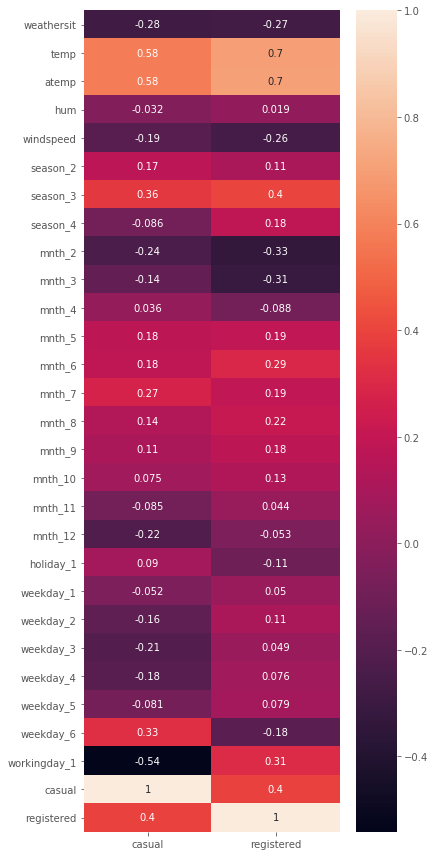

In [27]:
combined_data = pd.concat([numerical_data_2011, data_2011[['casual', 'registered']]], axis=1)
corr = combined_data.corr()


plt.figure(figsize=(6, 12))
sns.heatmap(corr.loc[:, ['casual', 'registered']], annot=True)
plt.tight_layout()

## Inferences from correlation plots

### Casual.
1. `workingday_1` is negatively correlated(-0.54), as expected.
2. even `weekday_6`, i.e. Sunday behaves as expected.
    - people are free, thus would love to rent out.
3. `weekday_2`, `weekday_3` and `weekday_4` behave appropriately.
    - these are Wednesday, Thursday and Friday.
    - surprisingly, tuesday doesn't seem to have a positive correlation.<font color="red">check this!!!</font>
    
4. 

### Registered.
1. `workingday_1` is positively correlated(0.31), as expected.
2. even `weekday_6`, i.e. Sunday behaves as expected.
    - people are free, i.e. don't need to go to work, hence registered users don't rent out on Sundays.
    - Wednesday seems to have some abrupt correlation bump, in comparison to other days. <font color="red">check this!!!</font>
    

### Divide the dataset into training and test sets

## we will be first dealing with casual renters

In [19]:
X, y = normalized_data_2011, data_2011['casual']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

print("the shape of x-train is {}, y-train is {}, x-test is {}, y-test is {}.".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

the shape of x-train is (255, 27), y-train is (255,), x-test is (110, 27), y-test is (110,).


* Since scikit-learn doesn't provide with the results of the estimates , i.e. mean value and std. error in the estimation of weights, we resort to `statsmodels`.

* OLS, i.e. ordinary least squares regression is used, from the [`statsmodels`](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html?highlight=ols#statsmodels.regression.linear_model.OLS) module. 

In [20]:
import statsmodels.api as smapi

model = smapi.OLS(y_train, x_train)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 casual   R-squared (uncentered):                   0.895
Model:                            OLS   Adj. R-squared (uncentered):              0.883
Method:                 Least Squares   F-statistic:                              74.72
Date:                Thu, 01 Apr 2021   Prob (F-statistic):                    7.45e-97
Time:                        15:08:17   Log-Likelihood:                         -1805.2
No. Observations:                 255   AIC:                                      3662.
Df Residuals:                     229   BIC:                                      3754.
Df Model:                          26                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

## Conceptual interpretation of Confidence interval

- Confidence intervals use the variability of your data to assess the precision or accuracy of your estimated statistics(here estimated statistic is the weight for each feature).

- it captures the margin of error
    - error = $\frac{CI_{upper} - CI_{lower}}{2}$
    
- hence a wider confidence interval means that estimation has a larger margin of error.
    - for instance, `temperature` has an interval from 181 to 2493, i.e. the `temperature` feature can have weights in this range, depending upon the data supplied.
    
    - Wide confidence intervals mean that your sample size was too small.
- If the confidence interval is relatively narrow (e.g. 0.70 to 0.80), the effect size is known precisely.  
    - If the interval is wider (e.g. 0.60 to 0.93) the uncertainty is greater. 
    - Intervals that are **very wide** (e.g. 0.50 to 1.10) indicate that we have **little knowledge about the effect and that further information is needed**.

In [21]:
def create_dataframe_from_confidence_intervals(confid_interv):
    columns = ['feature', 'weight']
    num_features = confid_interv.shape[0]
    value_list = []
    for i in range(num_features):
        curr_row = confid_interv.iloc[i, :]
        value_list.append([curr_row['index'], curr_row[0]])
        value_list.append([curr_row['index'], curr_row[1]])
    df = pd.DataFrame(columns=columns, data=value_list)
    return df

# confidence intervals
confid_interv = results.conf_int().reset_index()
display(confid_interv.head())

,index,0,1
0,weathersit,-671.559540,-334.189199
1,temp,-260.050133,4430.101840
2,atemp,-3561.701371,1341.958065
3,hum,339.557340,879.328541
4,windspeed,-402.912893,116.372499


it would be better, from the perspective of visualising weight plots, to sort all features in the decreasing order of the width of their confidence intervals.

,index,0,1,interv_width
0,weathersit,-671.559540,-334.189199,337.370342
1,temp,-260.050133,4430.101840,4690.151973
2,atemp,-3561.701371,1341.958065,4903.659436
3,hum,339.557340,879.328541,539.771201
4,windspeed,-402.912893,116.372499,519.285392




decrease sorted confidence intervals dataframe....


,index,0,1,interv_width
2,atemp,-3561.701371,1341.958065,4903.659436
1,temp,-260.050133,4430.101840,4690.151973
13,mnth_7,-283.988118,697.917557,981.905676
14,mnth_8,-405.359285,528.175627,933.534912
12,mnth_6,-206.079166,663.132832,869.211998


,feature,weight
0,atemp,-3561.701371
1,atemp,1341.958065
2,temp,-260.050133
3,temp,4430.101840
4,mnth_7,-283.988118


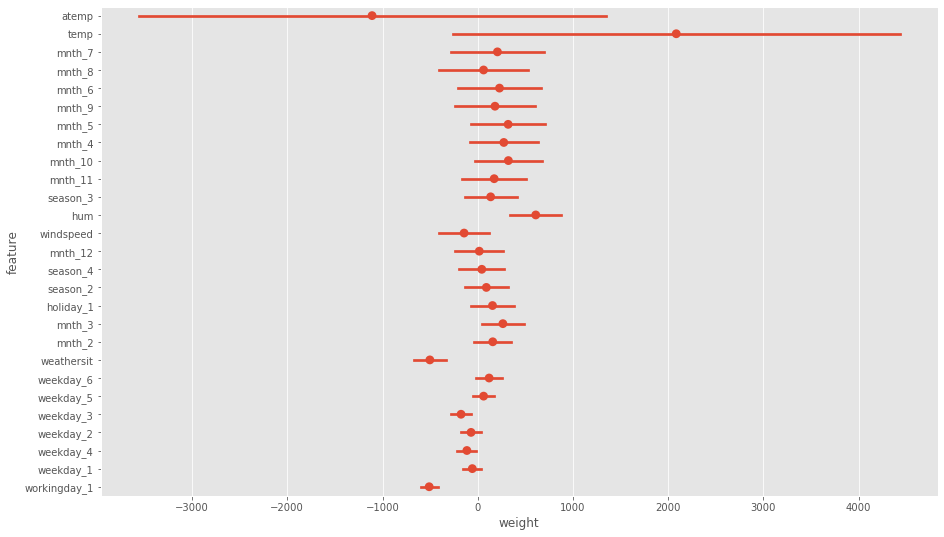

In [22]:
confid_interv['interv_width'] = abs(confid_interv[0]-confid_interv[1])
display(confid_interv.head())

# reverse sort the confidence intervals based on the order of their widths
confid_interv.sort_values(by='interv_width', ascending=False, inplace=True)
print("\n\ndecrease sorted confidence intervals dataframe....")
display(confid_interv.head())

modified_confid_interv = create_dataframe_from_confidence_intervals(confid_interv)
display(modified_confid_interv.head())

plt.style.use('ggplot')

plt.figure(figsize=(15, 9))
sns.pointplot(x="weight", y="feature", data=modified_confid_interv, join=False)

# 2012 dataset

* check whether the following fields are normalized.
    - `temp`
    - `atemp`
    - `windspeed`
    - `hum`

In [4]:
feature_list = ['temp', 'atemp', 'windspeed', 'hum']
for feature in feature_list:
    print("for feature {}, min = {}, max = {}.".format(feature, min(data_2012[feature]), max(data_2012[feature])))

for feature temp, min = 0.0591304, max = 0.861667.
for feature atemp, min = 0.0790696, max = 0.8408959999999999.
for feature windspeed, min = 0.0223917, max = 0.507463.
for feature hum, min = 0.0, max = 0.9725.


hence they <font color="red">aren't truly normalized</font>.
* though the values are between 0 and 1, the **min** and **max** should have been **exactly 0 and 1**.
* thus we need to normalize(min-max normalization) all features.

In [5]:
x = data_2012['casual']+data_2012['registered'] ==  data_2012['cnt']
x.value_counts()

True    731
dtype: int64

Thus, casual+registered = total counts of bike rented for the day.\
Hence, we now have **2 problem statements(per year), instead of 1**.
1. <font color="Red">predict, based on these environmental conditions, how many **casual renters** rented a bike on a day?</font>
2. <font color="Red">predict, based on these environmental conditions, how many **registered renters** rented a bike on a day?</font>

<font size="4">Checking the monthly counts of the dataset</font>

In [10]:
print("months for 2012 = {}".format(np.unique(data_2012['mnth'])))

months for 2012 = [ 1  2  3  4  5  6  7  8  9 10 11 12]


Hence we can now comfortably compare them.

In [12]:
print("monthly number of entries for 2012:\n{}".format(
    dict(zip(calendar.month_name[1:], data_2012['mnth'].value_counts().sort_index().values))
))

monthly number of entries for 2012:
{'January': 31, 'February': 29, 'March': 31, 'April': 30, 'May': 31, 'June': 30, 'July': 31, 'August': 31, 'September': 30, 'October': 31, 'November': 30, 'December': 31}


## Handling Categorical features

In [8]:
print("categories for season:", data['season'].unique())
print("categories for year:", data['yr'].unique())
print("categories for month:", data['mnth'].unique())
print("categories for holiday:", data['holiday'].unique())
print("categories for weekday:", data['weekday'].unique())
print("categories for workingday:", data['workingday'].unique())
print("categories for weathersit:", data['weathersit'].unique())

categories for season: [1 2 3 4]
categories for year: [0 1]
categories for month: [ 1  2  3  4  5  6  7  8  9 10 11 12]
categories for holiday: [0 1]
categories for weekday: [6 0 1 2 3 4 5]
categories for workingday: [0 1]
categories for weathersit: [2 1 3]


Weather situtation(`weathersit`) **could be thought** of as an <u>ordinal variable</u>, since the encoding is based on the severity of weather.

In [ ]:
categorical_features = [
    'season',
    'mnth',
    'holiday',
    'weekday',
    'workingday'
]

# notice categorical_features excludes weathersit.

for feature in categorical_features:
    treatment_mat = pd.get_dummies(data[feature], drop_first=True)
    current_categories = treatment_mat.columns
    treatment_mat.columns = ['{}_{}'.format(feature, i) for i in current_categories]
    data.drop([feature], axis=1, inplace=True)
    data = pd.concat([data, treatment_mat], axis=1)

print("after one-hot encoding all categorical features...")
display(data.head())

# label encode the weathersit feature

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['weathersit'] = le.fit_transform(data['weathersit'])

print("after label encoding the weathersit feature....")
display(data.head())

## normalize the numerical variables

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

numerical_features = [i for i in data.columns if i not in ['cnt', 'registered', 'casual']]
numerical_data = pd.DataFrame(mm.fit_transform(data.loc[:, numerical_features]), columns=numerical_features)

display(numerical_data.head())

as all features are now included, the `numerical_data` is actually the normalized important dataset.

In [ ]:
normalized_data = numerical_data.copy()

## New feature interpretation

1. season_2, season_3, season_4 denote spring, summer and fall respectively.
    1. when all the 3 are 0, it means winter.
2. yr_1 means 2012, if 0 then thats 2011.
3. mnth_2 to mnth_12 means Feb-December, when all of these are 0s, it means January.
4. weekday_1 to weekday_6 means Monday to Saturday, all 0s means Sunday.
5. `weathersit_2` means
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
6. `weathersit_3` : Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - when both are 0, it means Clear, Few clouds, Partly cloudy, Partly cloudy

## Correlation plots
1. since we have 2 problems, i.e. predict `casual` and `registered`, we would have 2 columns in the heatmap.

In [ ]:
complete_data = pd.concat([new_X, y], axis=1)
corr = complete_data.corr()

plt.figure(figsize=(6, 20))
sns.heatmap(corr.loc[:, ['casual']], annot=True)
plt.tight_layout()

### Divide the dataset into training and test sets

## we will be first dealing with casual renters

In [ ]:
X, y = normalized_data, data['casual']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

print("the shape of x-train is {}, y-train is {}, x-test is {}, y-test is {}.".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

* Since scikit-learn doesn't provide with the results of the estimates , i.e. mean value and std. error in the estimation of weights, we resort to `statsmodels`.

* OLS, i.e. ordinary least squares regression is used, from the [`statsmodels`](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html?highlight=ols#statsmodels.regression.linear_model.OLS) module. 

In [ ]:
import statsmodels.api as smapi

model = smapi.OLS(y_train, x_train)
results = model.fit()
print(results.summary())

In [ ]:
# confidence intervals
confid_interv = results.conf_int().reset_index()
display(confid_interv.head())

it would be better, from the perspective of visualising weight plots, to sort all features in the decreasing order of the width of their confidence intervals.

In [ ]:
confid_interv['interv_width'] = abs(confid_interv[0]-confid_interv[1])
display(confid_interv.head())

# reverse sort the confidence intervals based on the order of their widths
confid_interv.sort_values(by='interv_width', ascending=False, inplace=True)
print("\n\ndecrease sorted confidence intervals dataframe....")
display(confid_interv.head())

modified_confid_interv = create_dataframe_from_confidence_intervals(confid_interv)
display(modified_confid_interv.head())

plt.style.use('ggplot')

plt.figure(figsize=(15, 9))
sns.pointplot(x="weight", y="feature", data=modified_confid_interv, join=False)

## Interpretation of the observed interval data

1. `yr_1` is the one with the least width of confidence interval, i.e. its weight is the easiest to determine.
    - notice that this has a high positive weight of 329.536(from results.summary()) hence if the year was 2011, a positive effect was observed on the number of casual renters, i.e. they increased.
    - this basically means that their sales on casual renters increased in 2011, as opposed to 2010.
    - this could be attributed to the fact that Capital Bikeshare could have become famous in 2011.


2. the `workingday_1`, i.e. whether the day was a working day or not had the least confidence interval, i.e. lest difficult to estimate its importance/weight.
    - its further observed that this feature has a negative weight, i.e. if its a work day, number of casual renters decreases.
    - this is quite logical, since such casual renters could be thought of as office goers(who have considerably high chances of being *registered* users) who rent out to occasionally go out for a bike ride, on non-working days.


3. `weekdays` are from 0-6, i.e. day of the week, from Monday to Sunday.
    - among these, weekday_5 and weekday_6, i.e. Saturday and Sunday have been given a positive large weights, with wider confidence intervals.
    - this can be supported by the generic logic that the propensity of people to bike during the weekends is greater since they don't have any job to go to.


4. `weathersit` has been given a **<font color="Red">negative weight</font>**, and has a wider confidence intervals than the features previously talked about.
    
    - it may be that many entries have a higher weathersit value, meaning bad/severe weather, and a corresponding lower `casual` value.
    - this could be explored by <font color="green">treating this as a nominal variable</font><font color="red"> rather than an ordinal one</font>.


5. `months`
    - are from 1 - 12, i.e. january to december.
    - as we go from february(`mnth_2`) to march(`mnth_3`), the weight and the width of the confidence interval changes, signifying that people love to rent out bikes and go when the season of spring arrives, i.e. pleasant weather.
    - again, `mnth_4` to `mnth_5`(april to may), the weight estimates decreases but the confidence interval width increases. this may signifiy that increasing heat of the environment is also a negative sign in terms of casual renters.
    - `mnth_10`, i.e. October, i.e. October-heat is where the weather gets pleasant again, is what may be the reason behind a large positive weight.
        - additionally, right from `mnth_7` to `mnth_10`, the weights increase but the confidence interval-width decreases.
        - this may mean bettering of weather is increasing renting propensity, and from the P.O.V. of the model, it becomes more clear to estimate the importance of a particular month.
        
    - checking <font color="red">number of workdays per month</font> and <font color="red">number of holidays per month</font> could help in assessing why a particular month may have a greater number of casual renters.
    
    - checking <font color="red">temperature and month correlation</font> may help this as well.

6. `holiday_1`
    - this surprisingly has a quite small weight estimate, and the corresponding confidence interval even spans negative weight values.
    


7. `temp` and `atemp` have the largest confidence intervals.
    - `temp` has the largest weight, meaning the model thinks that temperature of the day was the most important factor in determining the number of casusal renters.
    - its quite weird that the model put a high **positive** weight on the temperature feature, whereas in reality it should have a negative impact.
    - this is unless lower temperatures mean **lower temperatures** , i.e. below 18$^{\circ}$C $\approx $
    - this could be checked by **<font color="Red">plotting histogram distributions and correlation plots for `temp vs casual` and `atemp vs casual`</font>**.


## Correlation plot of `casual` vs other features

In [ ]:
complete_train_data = pd.concat([x_train, y_train], axis=1)
casual_corr = complete_train_data.corr().loc[:, ['casual']].copy()
casual_corr.sort_values(by='casual', inplace=True)

plt.figure(figsize=(6, 20))
sns.heatmap(casual_corr, annot=True)
plt.tight_layout()

In [ ]:
interested_features = ['mnth_{}'.format(i) for i in range(2, 13)]
interested_features += ['holiday_1', 'temp', 'atemp']
interested_features_corr = complete_train_data.loc[:, interested_features].corr().copy()


plt.figure(figsize=(15, 8))
sns.heatmap(interested_features_corr, annot=True)
plt.tight_layout()

- as we can see, `mnth_2` is the least correlated with `temp` and `atemp`
    - it was also in negative correlation(-0.27) with `casual`.
    - this could mean that February is quite cold, thus people don't want to cycle out.
    - this can be confirmed by plotting the distribution of `temp` and `atemp` for `mnth_2=1`.

In [ ]:
# plot atemp and temp for mnth_2=1, against the overall temperature distribution.

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.distplot(
    complete_train_data[complete_train_data['mnth_2'] == 1]['atemp'], 
    kde=True, 
    hist=False, 
    label="atemp-feb",
    ax=ax[0]
)
sns.distplot(
    complete_train_data['atemp'], 
    kde=True, 
    hist=False, 
    label="atemp",
    ax=ax[0]
)

sns.distplot(
    complete_train_data[complete_train_data['mnth_2'] == 1]['temp'], 
    kde=True, 
    hist=False, 
    label="temp-feb",
    ax=ax[1]
)
sns.distplot(
    complete_train_data['temp'], 
    kde=True, 
    hist=False, 
    label="temp",
    ax=ax[1]
)


# number of holidays 
print("For the month of February(both years 2011 and 2012, % of holidays are value counts for holiday_1 are \n{}".format(
    complete_train_data[complete_train_data['mnth_2']==1]['holiday_1'].value_counts())
     )
print("For the complete training data, value counts for holiday_1 are \n{}".format(
    complete_train_data['holiday_1'].value_counts())
     )

display(complete_train_data[complete_train_data['mnth_2'] == 1]['yr_1'].value_counts())

# # number of workdays


# plt.tight_layout()

- hence we clearly see that february has quite low temperatures, when compared to the generic temperature distribution.

### Histogram plots for `atemp` and `temp`

In [ ]:
# sns.distplot(x_train['temp'], hist=False, bins=20)
v = pd.DataFrame(data=mm.inverse_transform(x_train), columns=x_train.columns)
sns.distplot(v['temp'], hist=False, kde=True, label="temp")
sns.distplot(v['atemp'], hist=False, kde=True, label="atemp")
plt.legend()

- the plots should have displayed the actual temperature in $^{\circ}$C, but since it was *normalized* by the UCI repository managers, even after inverse transforming the values are between 0 and 1.

- [Kaggle](https://www.kaggle.com/c/bike-sharing-demand/data) has a similar dataset for bike sharing, obtained from the exact same source, the UCI repository, i.e. Capital Bikeshare's data.
    - the only difference is that kaggle has the pre-normalized distribution of the dataset, hence it would be better to use kaggle.

## Treating `weathersit` as a nominal variable.

In [ ]:
new_X = X.copy()
new_X['weathersit'] = le.inverse_transform(data['weathersit'])
display(new_X.head())

ws_nominal_coded = pd.get_dummies(new_X['weathersit'], drop_first=True)
current_categories = ws_nominal_coded.columns
ws_nominal_coded.columns = ['{}_{}'.format('weathersit', i) for i in current_categories]
new_X.drop(['weathersit'], axis=1, inplace=True)
new_X = pd.concat([new_X, ws_nominal_coded], axis=1)

print("After nominal encoding of weather situation...")
display(new_X.head())

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=2021)
print("the shape of x-train is {}, y-train is {}, x-test is {}, y-test is {}.".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

model = smapi.OLS(y_train, x_train)
results = model.fit()
print(results.summary())

# confidence intervals
new_confid_interv = results.conf_int().reset_index()
display(new_confid_interv.head())

new_confid_interv['interv_width'] = abs(new_confid_interv[0]-new_confid_interv[1])
display(new_confid_interv.head())

# reverse sort the confidence intervals based on the order of their widths
new_confid_interv.sort_values(by='interv_width', ascending=False, inplace=True)
print("\n\ndecrease sorted confidence intervals dataframe....")
display(new_confid_interv.head())

new_modified_confid_interv = create_dataframe_from_confidence_intervals(new_confid_interv)
display(new_modified_confid_interv.head())

plt.style.use('ggplot')

plt.figure(figsize=(15, 9))

sns.pointplot(x="weight", y="feature", data=new_modified_confid_interv, join=False)


## Effect plot

Construct the effect matrix from the weight vector and feature matrix.

In [ ]:
weights = results.params
features = x_train.columns

effect_data = x_train.copy()

for feature in features:
    effect_data[feature] *= weights[feature]

In [ ]:
display(effect_data.head(10))

In [ ]:
temp_data = []
for j in range(len(features)):
    for i in range(effect_data.shape[0]):
        temp_data.append([features[j], effect_data.iloc[i, j]])

temp_df = pd.DataFrame(columns=['feature_name', 'effect'], data=temp_data)
display(temp_df.head())

plt.figure(figsize=(15, 10))
sns.boxplot(x='effect', y='feature_name', data=temp_df)

- too many outliers for too many features.
    - it would be better to plot them separately.

In [ ]:
good_features = [
    'temp',
    'atemp',
    'hum',
    'windspeed',
    'season_2',
    'season_3',
    'yr_1',
    'workingday_1',
    'weathersit_2'
]

bad_features = [i for i in effect_data.columns if i not in good_features]

def get_tempdf_given_effect_data(effect_data):
    features = effect_data.columns
    temp_data = []
    for j in range(len(features)):
        for i in range(effect_data.shape[0]):
            temp_data.append([features[j], effect_data.iloc[i, j]])
            
    temp_df = pd.DataFrame(columns=['feature_name', 'effect'], data=temp_data)
    return temp_df

bad_feature_effect_df = get_tempdf_given_effect_data(effect_data.loc[:, bad_features])
good_feature_effect_df = get_tempdf_given_effect_data(effect_data.loc[:, good_features])

fig, ax = plt.subplots(2, 1, figsize=(15, 18))
sns.boxplot(x='effect', y='feature_name', data=bad_feature_effect_df, ax=ax[0])
sns.boxplot(x='effect', y='feature_name', data=good_feature_effect_df, ax=ax[1])

## Inference from effect plots

## correlation with `casual`

In [ ]:
complete_data = pd.concat([new_X, y], axis=1)
corr = complete_data.corr()

plt.figure(figsize=(6, 20))
sns.heatmap(corr.loc[:, ['casual']], annot=True)
plt.tight_layout()

## inference from correlation map.